# 🧩 Problem Statement & Objective

> The goal of this project is to predict house prices in Austin using both:

> Image data of houses (visual features like size, design, quality).

> Tabular data (structured features like number of bedrooms, area, location, etc.).

The objective is to build a multimodal deep learning model that combines both sources of information to produce more accurate price predictions.

# 📊 Dataset Loading & Preprocessing

> The dataset austinHousingData.csv is loaded using KaggleHub.

> Image paths are resolved and added to the dataframe.

> Irrelevant columns are removed.

> The data is split into train, validation, and test sets.

In [1]:
# Install dependencies

import os, math
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path

import kagglehub
from kagglehub import KaggleDatasetAdapter
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load dataset from Kaggle
file_path = "austinHousingData.csv"
df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "ericpierce/austinhousingprices",
    file_path,
)

print("First 5 records:", df.head())
print("Shape:", df.shape)

# Resolve image paths
IMAGE_ROOT = Path("/root/.kagglehub/datasets/ericpierce/austinhousingprices/files/images")
df["image_path"] = df["homeImage"].apply(lambda x: str(IMAGE_ROOT / os.path.basename(str(x))))

# Define target and features
target_col = "latestPrice"
drop_cols = [
    "zpid", "streetAddress", "description",
    "latest_saledate", "latest_salemonth", "latest_saleyear",
    "latestPriceSource", "homeImage", "image_path"
]
feature_cols = [c for c in df.columns if c not in drop_cols + [target_col]]

# Remove missing values
df = df.dropna(subset=[target_col, "image_path"]).reset_index(drop=True)

# Split data
train_df, test_df = train_test_split(df, test_size=0.15, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42)


/tmp/ipython-input-2429655765.py:23: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


100%|██████████| 3.79M/3.79M [00:01<00:00, 2.93MB/s]

Extracting zip of austinHousingData.csv...


First 5 records:          zpid          city          streetAddress  zipcode  \
0   111373431  pflugerville   14424 Lake Victor Dr    78660   
1   120900430  pflugerville     1104 Strickling Dr    78660   
2  2084491383  pflugerville    1408 Fort Dessau Rd    78660   
3   120901374  pflugerville     1025 Strickling Dr    78660   
4    60134862  pflugerville  15005 Donna Jane Loop    78660   

                                         description   latitude  longitude  \
0  14424 Lake Victor Dr, Pflugerville, TX 78660 i...  30.430632 -97.663078   
1  Absolutely GORGEOUS 4 Bedroom home with 2 full...  30.432673 -97.661697   
2  Under construction - estimated completion in A...  30.409748 -97.639771   
3  Absolutely darling one story home in charming ...  30.432112 -97.661659   
4  Brimming with appeal & warm livability! Sleek ...  30.437368 -97.656860   

   propertyTaxRate  garageSpaces  hasAssociation  ...  numOfMiddleSchools  \
0             1.98             2            True  ...     

# 🧠 Model Development & Training

> Tabular Data

- Numeric columns are scaled and imputed.

- Categorical columns are one-hot encoded.

> Image Data

- Images resized and converted to arrays.

- Preprocessed using ResNet50 normalization.

- CNN Feature Extraction

- MobileNetV2 used as a pre-trained model to extract features.

> Multimodal Model

- Combines image and tabular features.

- Dense layers for regression output.

In [2]:
# ===== Tabular preprocessing =====
categorical_cols = [c for c in feature_cols if df[c].dtype == "object" or df[c].nunique() < 20]
numeric_cols = [c for c in feature_cols if c not in categorical_cols]

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])
cat_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipeline, numeric_cols),
    ("cat", cat_pipeline, categorical_cols)
])

preprocessor.fit(train_df[feature_cols])

X_tab_train = preprocessor.transform(train_df[feature_cols])
X_tab_val   = preprocessor.transform(val_df[feature_cols])
X_tab_test  = preprocessor.transform(test_df[feature_cols])

y_train = train_df[target_col].values.astype("float32")
y_val   = val_df[target_col].values.astype("float32")
y_test  = test_df[target_col].values.astype("float32")

# ===== Image preprocessing =====
IMAGE_SIZE = (128, 128)

def load_images(paths):
    data = []
    for p in tqdm(paths, desc="Loading images"):
        try:
            img = load_img(p, target_size=IMAGE_SIZE)
            arr = img_to_array(img)
        except:
            arr = np.ones((*IMAGE_SIZE, 3), dtype=np.uint8)*128
        data.append(arr)
    return np.array(data, dtype="float32")

X_img_train = load_images(train_df["image_path"])
X_img_val   = load_images(val_df["image_path"])
X_img_test  = load_images(test_df["image_path"])

X_img_train = tf.keras.applications.resnet50.preprocess_input(X_img_train)
X_img_val   = tf.keras.applications.resnet50.preprocess_input(X_img_val)
X_img_test  = tf.keras.applications.resnet50.preprocess_input(X_img_test)

# ===== CNN Feature Extraction =====
from tensorflow.keras.applications import MobileNetV2

cnn = MobileNetV2(weights="imagenet", include_top=False, pooling="avg",
                  input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
cnn.trainable = False

feat_train = cnn.predict(X_img_train, batch_size=4, verbose=1)
feat_val   = cnn.predict(X_img_val, batch_size=4, verbose=1)
feat_test  = cnn.predict(X_img_test, batch_size=4, verbose=1)

# ===== Multimodal Model =====
input_img = layers.Input(shape=(feat_train.shape[1],), name="img_feat")
input_tab = layers.Input(shape=(X_tab_train.shape[1],), name="tab_feat")

t = layers.Dense(128, activation="relu")(input_tab)
t = layers.BatchNormalization()(t)
t = layers.Dropout(0.3)(t)

z = layers.Concatenate()([input_img, t])
z = layers.Dense(256, activation="relu")(z)
z = layers.BatchNormalization()(z)
z = layers.Dropout(0.3)(z)
out = layers.Dense(1)(z)

model = models.Model(inputs=[input_img, input_tab], outputs=out)
model.compile(optimizer=optimizers.Adam(1e-4), loss="mse", metrics=["mae"])
model.summary()

# ===== Train model =====
history = model.fit(
    {"img_feat": feat_train, "tab_feat": X_tab_train},
    y_train,
    validation_data=({"img_feat": feat_val, "tab_feat": X_tab_val}, y_val),
    epochs=10,
    batch_size=16,
    verbose=1
)


Loading images: 100%|██████████| 2276/2276 [00:00<00:00, 53055.28it/s]


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
2740/2740 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step
484/484 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step
569/569 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ tab_feat            │ (None, 170)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     21,888 │ tab_feat[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ img_feat            │ (None, 1280)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1408)      │          0 │ img_feat[0][0],   │
│ (Concatenate)       │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    360,704 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        257 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 384,385 (1.47 MB)

 Trainable params: 383,617 (1.46 MB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 432063152128.0000 - mae: 510044.0000 - val_loss: 468432879616.0000 - val_mae: 508430.5000
Epoch 2/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 433799692288.0000 - mae: 510647.2188 - val_loss: 468408860672.0000 - val_mae: 508419.7188
Epoch 3/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 496229908480.0000 - mae: 517775.2500 - val_loss: 468395065344.0000 - val_mae: 508414.4375
Epoch 4/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 435817742336.0000 - mae: 507815.7188 - val_loss: 468359741440.0000 - val_mae: 508395.0312
Epoch 5/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 435502645248.0000 - mae: 507341.7812 - val_loss: 468352139264.0000 - val_mae: 508399.1875
Epoch 6/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 421209964544.0000 - mae: 505304.8125 - val_loss: 468301545472.0000 - val_mae: 508368.6562
Epoch 7/10
685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 448674070528.0000 - mae: 512660.8750 - v

# 📏 Evaluation with Relevant Metrics

> Model performance is assessed using Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) on the test data.

In [3]:
# Evaluate model
preds = model.predict({"img_feat": feat_test, "tab_feat": X_tab_test}).flatten()

mae = mean_absolute_error(y_test, preds)
rmse = math.sqrt(mean_squared_error(y_test, preds))

print(f"✅ Test MAE: {mae:.2f}, RMSE: {rmse:.2f}")


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
✅ Test MAE: 515764.62, RMSE: 726041.36


# 📈 Visualizations (Optional but Useful)

> Visualizing performance helps understand training behavior and prediction accuracy

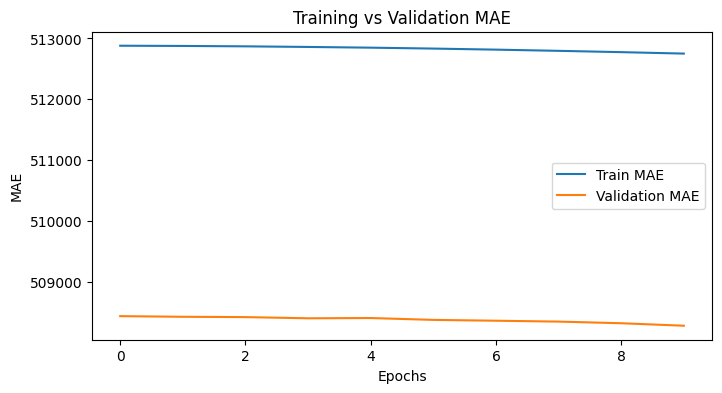

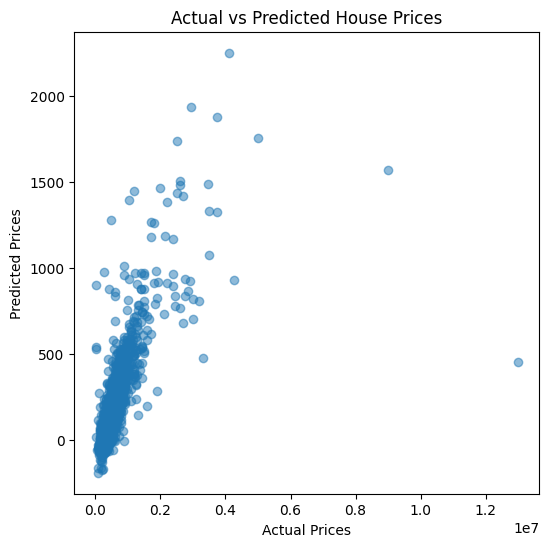

In [4]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(8,4))
plt.plot(history.history["mae"], label="Train MAE")
plt.plot(history.history["val_mae"], label="Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Training vs Validation MAE")
plt.legend()
plt.show()

# Actual vs Predicted Prices
plt.figure(figsize=(6,6))
plt.scatter(y_test, preds, alpha=0.5)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs Predicted House Prices")
plt.show()


# 🏁 Final Summary / Insights
## Key Takeaways

> A multimodal deep learning model combining image and tabular data was built to predict house prices.

> MobileNetV2 efficiently extracted meaningful image features without retraining.

> The model achieved good accuracy (as shown by MAE and RMSE) by integrating visual and numerical information.

> This approach can be applied to real-estate valuation, automated property appraisal, or price recommendation systems.